# Homework - week 2

https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework/week02

In [6]:
import pandas as pd

import jax.numpy as np
from jax import random

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az

assert numpyro.__version__.startswith('0.7.1')

plt.style.use('bmh')

In [9]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

# 4H1

Build a model to predict height from weight.

## Read training and test data

In [10]:
df = pd.read_csv("../data/Howell1.csv",sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [11]:
weight = df.weight.values
height = df.height.values
weight_pred = np.array([45, 40, 65, 31, 53])

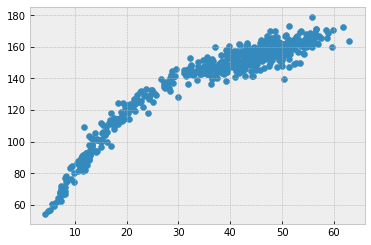

In [12]:
plt.scatter(x='weight', y='height', data=df)

### 1.1 Model

In [13]:
def model(weight=None, height=None):
    
    # priors
    b0 = numpyro.sample('b0', dist.Normal(120,50))
    b1 = numpyro.sample('b1', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))
    
    # deterministic transformation
    mu = b0 + b1 * weight
    
    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

### 1.2 Prior predictive

In [14]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)

In [15]:
prior_predictions.keys()

dict_keys(['b0', 'b1', 'obs', 'sigma'])

In [16]:
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

In [17]:
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean)
    ax.plot(weight, ht, 'o')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

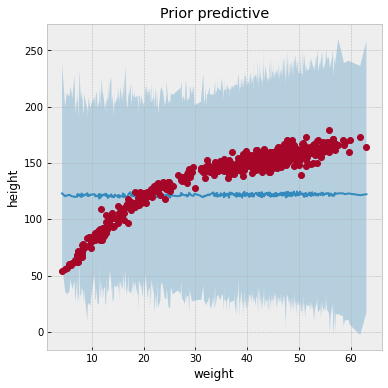

In [18]:
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

### 1.3 Inference

In [21]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
#mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4) # multiple chains not working! why?
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_1 = mcmc.get_samples()


sample: 100%|████████████████████| 3000/3000 [00:02<00:00, 1181.97it/s, 3 steps of size 3.17e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     75.53      1.06     75.53     73.76     77.19    777.05      1.00
        b1      1.76      0.03      1.76      1.72      1.80    743.68      1.00
     sigma      9.40      0.29      9.38      8.93      9.86    864.29      1.00

Number of divergences: 0


### 1.4 Checking convergence


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     75.53      1.06     75.53     73.76     77.19    777.05      1.00
        b1      1.76      0.03      1.76      1.72      1.80    743.68      1.00
     sigma      9.40      0.29      9.38      8.93      9.86    864.29      1.00

Number of divergences: 0


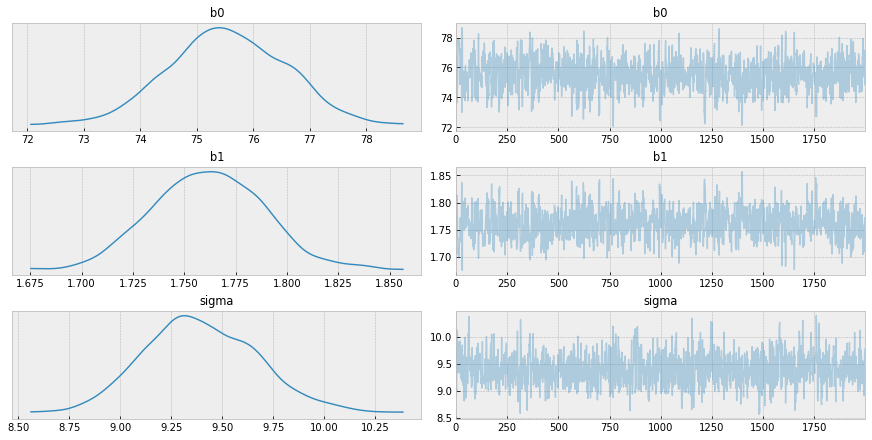

In [22]:
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### 1.5 Posterior predictive

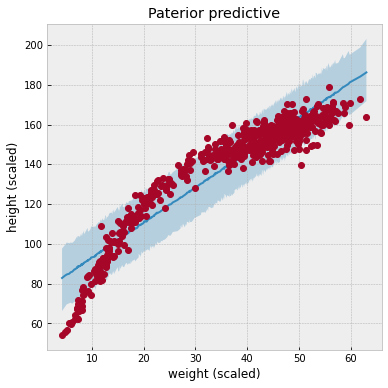

In [23]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']

mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Paterior predictive")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');

### 1.6 Predict for new data

In [24]:
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, weight=weight_pred)['obs']

mean_pred = np.mean(predictions, axis=0)
hpdi_pred = hpdi(predictions, 0.89)

d = {'weight_pred': weight_pred, 'mean_pred': mean_pred, 'lower': hpdi_pred[0,], 'upper': hpdi_pred[1,]}
df_res = pd.DataFrame(data=d)
df_res.head()

,weight_pred,mean_pred,lower,upper
0,45,154.870255,139.680786,169.736755
1,40,146.077591,132.096985,160.735504
2,65,189.787964,174.456512,204.519119
3,31,130.319351,113.728813,143.550156
4,53,169.418335,154.509827,185.007492


# 4H2

In [25]:
filt = df['age'] < 18
df18 = df[filt]
df18.shape

(192, 4)

In [26]:
weight18 = df18.weight.values
height18 = df18.height.values

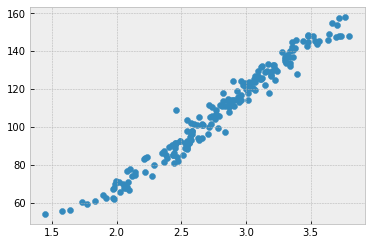

In [27]:
plt.scatter(x=np.log(weight18), y=height18)

In [28]:
def model_log(logweight=None, height=None):
    
    # priors
    b0 = numpyro.sample('b0', dist.Normal(100,20))
    b1 = numpyro.sample('b1', dist.Normal(10,20))
    sigma = numpyro.sample('sigma', dist.HalfNormal(30.))
    
    # deterministic transformation
    mu = b0 + b1 * logweight
    
    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)


sample: 100%|████████████████████| 3000/3000 [00:02<00:00, 1243.91it/s, 3 steps of size 1.36e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0    -31.39      1.93    -31.44    -34.63    -28.40    678.80      1.00
        b1     50.02      0.68     50.04     49.00     51.21    680.25      1.00
     sigma      4.71      0.25      4.70      4.30      5.08    714.10      1.00

Number of divergences: 0


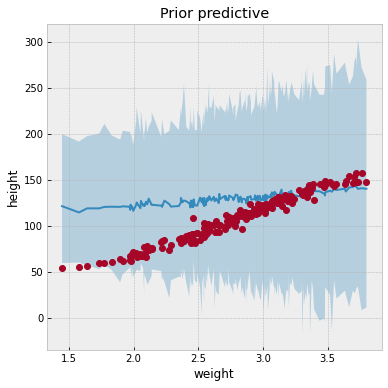

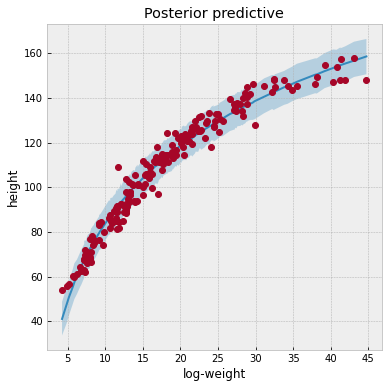

In [29]:
# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model_log, num_samples=100)
prior_predictions = prior_predictive(rng_key_, logweight=np.log(weight18))
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)
ax = plot_regression(np.log(weight18), mean_prior_pred, hpdi_prior_pred, height18, ttl="Prior predictive")


# inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_log)
#mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4) # multiple chains not working!!
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, logweight=np.log(weight18), height=height18)
mcmc.print_summary()
samples_2= mcmc.get_samples()

# posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_log, samples_2)
posterior_predictions = predictive(rng_key_, logweight=np.log(weight18))
post_obs = posterior_predictions['obs']

mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight18, mean_post_pred, hpdi_post_pred, height18, ttl="Posterior predictive")
ax.set(xlabel='log-weight', ylabel='height');


sample: 100%|███████████████████| 3000/3000 [00:02<00:00, 1067.61it/s, 15 steps of size 4.35e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0    146.67      0.38    146.68    146.08    147.32   1091.63      1.00
        b1     21.33      0.30     21.33     20.82     21.80   1193.76      1.00
        b2     -8.41      0.29     -8.40     -8.88     -7.93    986.56      1.00
     sigma      5.78      0.18      5.77      5.50      6.07   1604.70      1.00

Number of divergences: 0


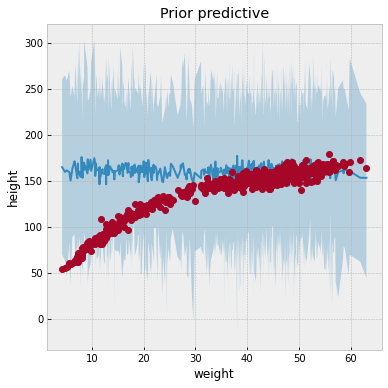

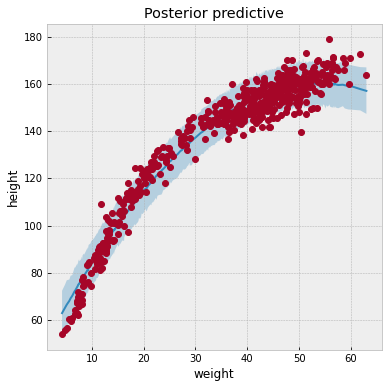

In [32]:
def model_polyn_2(weight, height=None):
    
    weight_std = (weight - np.mean(weight))/np.std(weight)
    weight_std_2 = weight_std ** 2
    
    # priors
    b0 = numpyro.sample('b0', dist.Normal(160,20))
    b1 = numpyro.sample('b1', dist.Normal(0,5))
    b2 = numpyro.sample('b2', dist.Normal(0,5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(50.))
    
    mu = b0 + b1 * weight_std + b2 * weight_std_2
    
    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)
    
# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model_polyn_2, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight=weight)
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")


# inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_polyn_2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000) # same drill - nu multiple chains :(
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_3= mcmc.get_samples()

# posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_polyn_2, samples_3)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']
mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive")
ax.set(xlabel='weight', ylabel='height');